grade: 5/5
# Exploring the Pronto Dataset

The Pronto Dataset has a wide variety of variables that can be explored to search for interesting and useful trends.  While developing this notebook, I had a hard time settling on what I wanted to analyze, so there are many steps that weren't actually used in the final results.  I included the weather data in case I wanted to use that, but I ended up focusing on searching for temporal factors that affected trip duration (e.g. does the day of the week have any effect on trip duration? How about the month of the year?)  as well as other aspects of the trip dataset.  

In summary, the problem I chose to investigate was how temporal factors affected the trip duration of the Pronto customer base.  The two questions I chose to analyze were:

(1) How and to what extent does the day of the week affect trip duration?  Does this change with the hour of the day?

(2) How and to what extend does the month of the year affect trip duration? Does this change with the hour of the day?

In [5]:
import os
import wget
import pandas as pd
import zipfile
import seaborn; seaborn.set()  # for plot stylings
import matplotlib.pyplot as plt
import numpy as np
import seaborn
seaborn.set()
%matplotlib inline
from pronto_utils import get_pronto_data, get_trip_data, download_if_needed, get_weather_data

C:\Users\koolk\Miniconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Here I load the weather dataset and create two versions: one with a standard index and another indexed by date.

In [6]:
#Throughout this notebook, quite a few data sets are developed.  I want to make sure to record them all here.  
#weather_data: original weather data set. Indexed by number.
#weather_data2: weather data indexed by date. Includes "Date2" column as np.int64 variable.

#trip_data: original trip data set. Indexed by number.  Includes normalized starttime and unnormalized starttime2 column.
#           Also includes row of ones to be used later to establish totals.
#trip_data2: trip data indexed by date.

#complete_data: weather data and trip data merged together indexed by date. Also includes column indicating the date of
#           the week.
#byhourdata: A selection of complete_data only including rides that started in a certain hour interval of time.

#times: date time index based on "starttime2" column.
#daily_data_sum: sum of trip data (nonsense trip data except for "ones" column) joined to the weather data.  Gives daily
#           totals of rides.


weather_data = get_weather_data()
pd.DatetimeIndex(weather_data.Date).normalize()
weather_data["Date"] = pd.DatetimeIndex(weather_data.Date).normalize()
weather_data["Date2"] = weather_data["Date"]
weather_data2 = weather_data.set_index("Date")
weather_data2 = weather_data2.dropna()

open_data_year_one.zip already exists


Using the data in np.int64 format, I plotted the mean temperature as a function of time to check that my dataset was working and to see if the given trends matched my intuition (e.g. a cold swing in winter and a hot swing in summer).

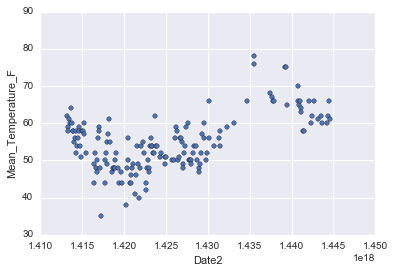

In [7]:
weather_data2['Date2'] = weather_data2.Date2.astype(np.int64)
weather_data2.plot(kind="scatter", x="Date2", y="Mean_Temperature_F")

Next, I set up my trip data for analysis.  I converted the trip duration data from seconds to minutes, and I created two separate data sets: one with a standard index and one indexed by date, similar to the weather data.  

In [8]:
trip_data = get_trip_data()

open_data_year_one.zip already exists


In [9]:
trip_data["starttime2"] = trip_data["starttime"]
trip_data["starttime"] = pd.DatetimeIndex(trip_data.starttime).normalize()
trip_data["starttime3"] = pd.DatetimeIndex(trip_data.starttime).normalize()
trip_data2 = trip_data.set_index("starttime")
trip_data2["tripduration"] = trip_data2["tripduration"] / 60
trip_data2["one"] = 1
trip_data["one"] = 1

I was then able to merge the two data sets.  I checked the weather data for immediate obvious trends-- such as trip duration as a function of temperature.  That didn't seem to correlate.  I'm sure that precipitation data would probably have affected trip duration, but iPython didn't seem to like the precipitation data for some reason.

In [10]:
complete_data=trip_data2.join(weather_data2)

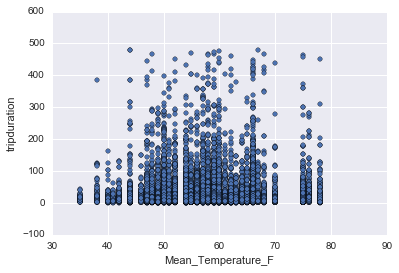

In [11]:
complete_data.plot(kind="scatter", x="Mean_Temperature_F", y="tripduration")

Something else that would be potentially useful to analyze was the number of trips per day.  This would require more manipulation of the trip dataset, because there are multiple rides in a day.  I was able to complete this function using resample, as in Homework 2.  I also created a few times variables for different datsets so I could use the grouby function in the future.

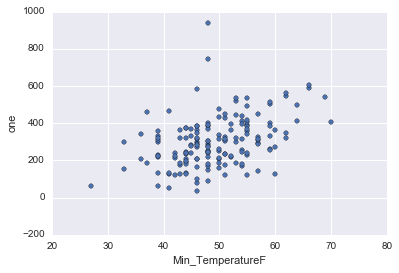

In [12]:
times = pd.DatetimeIndex(trip_data["starttime2"])
daily_data_sum = trip_data2.resample('1D', how = "sum", closed='left',label='left')
daily_data_sum = daily_data_sum.join(weather_data2)
daily_data_sum.plot(kind="scatter", x="Min_TemperatureF", y="one")
timesweather = pd.DatetimeIndex(daily_data_sum["Date2"])

# Widget 1: Trip Duration as a Function of Day of the Week

Now I started prepping for the interact widget.  I wanted to first create a plot of trip duration as a function of day of the week, but then also make a widget to adjust the time of day.  That way, you could explore how the time of day affects trip duration as well as time of day.  Just from my intuition, I thought that there would be some kind of split between weekends and weekdays due to commutes to work versus pleasure riding or errands.  If commutes tend to be longer, then trip duration should be longer during the week.  As for time of day, I thought there would be a similar trend, with trip duration spiking maybe at 8 am and 5 pm following commute patterns.

In [13]:
complete_data["DayofWeek"] = times.dayofweek
byhourdata = complete_data[times.hour==3]
#byhourdata
times2 = pd.DatetimeIndex(byhourdata["starttime2"])
bydyavg = byhourdata.groupby(times2.dayofweek)["tripduration"].mean()




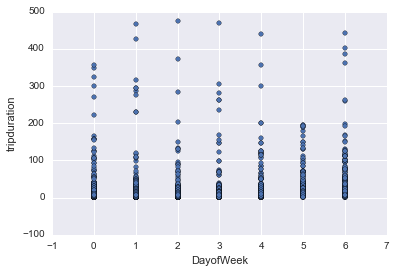

In [14]:
complete_data[times.hour==8].plot(kind="scatter", x="DayofWeek", y="tripduration")

One thing I had to do to make my data more comprehensible was the convert the scatter plot into a bar plot of trip duration averages.  Otherwise, the data doesn't mean a lot.

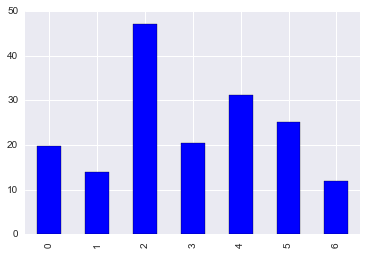

In [15]:
bydyavg.plot(kind="bar")

After many round of trial and error, I was able to get the interat widget to produce a plot of trip duration versus day of the week with a widget to adjust time of day!

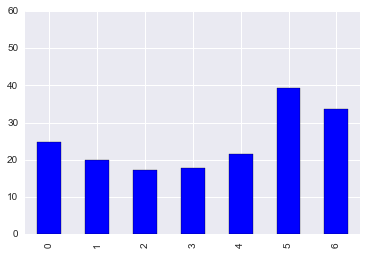

In [16]:
from ipywidgets import interact
def hourofday(hr):
    byhourdata = complete_data[times.hour==hr]
    times2 = pd.DatetimeIndex(byhourdata["starttime2"])
    bydyavg = byhourdata.groupby(times2.dayofweek)["tripduration"].mean()
    bydyavg.plot(kind="bar", ylim = [0,60])
interact(hourofday,
            hr=(0,23));

And for my final product, I was able to add an additional tab to explore how member type factors in as well.

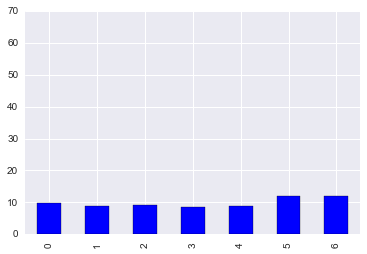

In [17]:
#usertype can be Annual Member or Short-Term Pass Holder

def hourofday2(hr, holdertype):
    byhourdata = complete_data[times.hour == hr]
    usertype = byhourdata["usertype"]
    byhourdata2 = byhourdata[usertype == holdertype]
    times2 = pd.DatetimeIndex(byhourdata2["starttime2"])
    bydyavg = byhourdata2.groupby(times2.dayofweek)["tripduration"].mean()
    bydyavg.plot(kind="bar", ylim = [0,70])
    
interact(hourofday2, 
             hr=(0,23), 
             holdertype=("Annual Member", "Short-Term Pass Holder"));

# Widget 2: Trip Duration as a Function of Month of the Year

Another aspect of the data I wanted to explore was how the month of the year affected trip duration.  I thought this one would exhibit more obvious trends than the day of the week, because month of the year, in a way, contains all the weather data (it's rainier and colder in winter, so rides should be shorter).  I included the similar capabilities of the previous widget-- looking at hour of the day and member type.

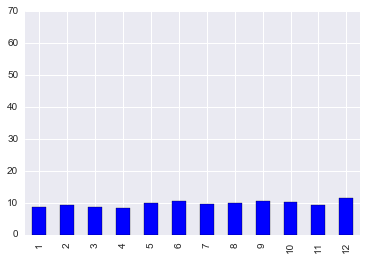

In [18]:
def hourofday3(hr, holdertype):
    byhourdata3 = complete_data[times.hour == hr]
    usertype2 = byhourdata3["usertype"]
    byhourdata4 = byhourdata3[usertype2 == holdertype]
    times3 = pd.DatetimeIndex(byhourdata4["starttime2"])
    bymthavg = byhourdata4.groupby(times3.month)["tripduration"].mean()
    bymthavg.plot(kind="bar", ylim = [0,70])
    
interact(hourofday3, 
             hr=(0,23), 
             holdertype=("Annual Member", "Short-Term Pass Holder"));

The tools that we learned this week are still new and seemingly foreign, but some of them are quickly becoming handy, the biggest one being help functionaility.  This homework was slightly harder, because we no longer had a nice outline of how to get from problem to solution-- and we had to determine the problem before we got to the solution!  This required some creativity.  I found myself using "?" quite a bit to check the documentation, but more often than not, I also went to stackoverflow as well.

The shortcuts come in really handy, but I still haven't developed a muscle memory for them.  As such, the "h" command comes in really handy, because I can easily find all the shortcuts available to me.  The ones I use the most are "Y" and "M", which let me switch a cell from code to markdown really easily.

I didn't find an immediate need to use any shell commands, and the only magic command I used so far is %matplotlib.  They could be fun to explore in the future, but the ones I really remembered from class, %history and %timeit, didn't seem to be useful for this homework. 
